<a href="https://colab.research.google.com/github/Nadian-Ali/ImageClassification/blob/main/CNN_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Train a CNN Classifer from scratch </h1>

In this note book we are going to train a simple CNN network for classificaiton of Lateral and PA x-ray images. 

In [1]:
#Import drive
from google.colab import drive
#Mount Google Drive
drive.mount("/content/drive", force_remount =True)

Mounted at /content/drive


In [ ]:
%pwd


'/content'

In [ ]:
%lsd

shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
ls: cannot open directory '.': Transport endpoint is not connected


In [2]:
%cd /content/drive/MyDrive/ImageClassification/Data

[Errno 2] No such file or directory: '/content/drive/MyDrive/ImageClassification/Data'
/content


<h1> Improt Packages </h1>

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model

<h1> Download Dataset </h1>

In [ ]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('/content/drive/MyDrive/ImageClassification/data', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [ ]:
!tar -xzvf "/content/drive/MyDrive/ImageClassification/data.tar.gz" # "/content/drive/My Drive/ImageClassification"

<h1>Dataset Root</h1>

In [4]:
data_dir = '/content/drive/MyDrive/ImageClassificationData/Data'

In [62]:
batch_size = 32
img_height = 256
img_width = 256

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  color_mode = "grayscale",
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 190 files belonging to 2 classes.
Using 152 files for training.


In [7]:
class_names = train_ds.class_names
print(class_names)

['AP', 'Lateral']


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  color_mode = "grayscale",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 190 files belonging to 2 classes.
Using 38 files for validation.


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
train_ds

<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>

In [10]:
normalization_layer = layers.Rescaling(1./255)

<h1>dataset transform for normalization</h1>

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

In [11]:
print(len(class_names))
num_classes = len(class_names)

2


<h1>Data augmentation </h1>

In [12]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  1)),
    layers.RandomFlip('horizontal'),
    layers.RandomZoom(0.1),
  ]
)

<h1> visualize augmentation<h1>

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [13]:
print(num_classes)

2


<h1>My Model</h1>

In [42]:
image_size = (256, 256)
def my_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(4, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D()(x)  
    x = layers.Conv2D(8, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(16, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(1,activation = 'sigmoid')(x)
    
    return keras.Model(inputs, outputs)


In [78]:
model_mine = my_model(input_shape=image_size + (1,), num_classes=num_classes)
#keras.utils.plot_model(model_mine, show_shapes=True)  #draw model if you want

In [79]:
model_mine.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.00001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [71]:
#create class weights

#wj is the weight for each class(j signifies the class)
#n_samplesis the total number of samples or rows in the dataset
#n_classesis the total number of unique classes in the target
#n_samplesjis the total number of rows of the respective class
# wj=n_samples / (n_classes * n_samplesj)

weight_for_0 = 190/(2*107)
weight_for_1 = 190/(2*83)
print(weight_for_0)
print(weight_for_1)
class_weight = {0: weight_for_0, 1: weight_for_1}


0.8878504672897196
1.144578313253012


In [80]:
epochs=180


history = model_mine.fit(
  train_ds, 
  validation_data=val_ds, 
  epochs=epochs,
  class_weight = class_weight,
  batch_size = 16,
  )

Epoch 1/180
19/19 [==============================] - 7s 288ms/step - loss: 0.6931 - accuracy: 0.5592 - val_loss: 0.6886 - val_accuracy: 0.5789
Epoch 2/180
19/19 [==============================] - 4s 232ms/step - loss: 0.6897 - accuracy: 0.5921 - val_loss: 0.6873 - val_accuracy: 0.5789
Epoch 3/180
19/19 [==============================] - 4s 231ms/step - loss: 0.6882 - accuracy: 0.6447 - val_loss: 0.6861 - val_accuracy: 0.6316
Epoch 4/180
19/19 [==============================] - 4s 231ms/step - loss: 0.6853 - accuracy: 0.6974 - val_loss: 0.6840 - val_accuracy: 0.6053
Epoch 5/180
19/19 [==============================] - 4s 235ms/step - loss: 0.6834 - accuracy: 0.6711 - val_loss: 0.6823 - val_accuracy: 0.6579
Epoch 6/180
19/19 [==============================] - 4s 232ms/step - loss: 0.6818 - accuracy: 0.6908 - val_loss: 0.6803 - val_accuracy: 0.6842
Epoch 7/180
19/19 [==============================] - 4s 233ms/step - loss: 0.6782 - accuracy: 0.7237 - val_loss: 0.6781 - val_accuracy: 0.7105

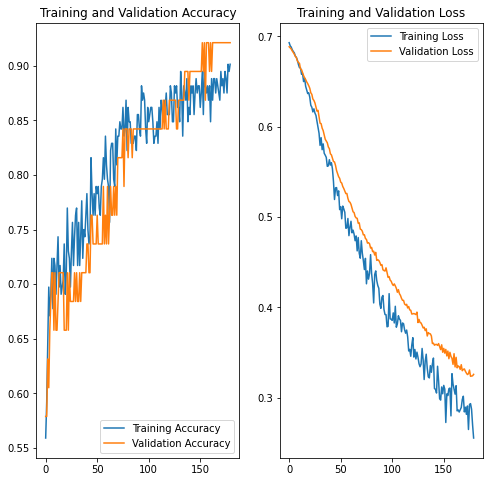

In [81]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<h1> Conclusions about the results</h1>

<h1>Predict new Data<h1>

In [ ]:
from tensorflow.python.tf2 import enabled

im_pd = '/content/drive/MyDrive/ImageClassification/flower_photos/daisy/286875003_f7c0e1882d.jpg'
im_ps = '/content/drive/MyDrive/ImageClassification/flower_photos/sunflowers/200557981_f800fa1af9.jpg'

img = tf.keras.utils.load_img(
    im_ps,
    color_mode = "grayscale", 
    target_size=(img_height, img_width),
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model_mine.predict(img_array)
#score = tf.nn.softmax(predictions[0])

print(predictions)
if predictions>0.5:
  print('image belongs to class sunflower')
else:
  print('image belongs to class daisy')  

[[0.9216224]]
image belongs to class sunflower


In [ ]:
from PIL import ImageOps

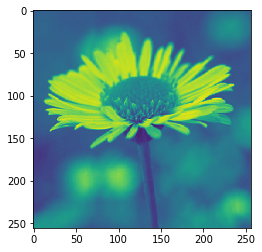

In [ ]:

img = ImageOps.grayscale(img)


<h1> Save Model <h1>

In [ ]:
from keras.models import load_model

model_mine.save('/content/drive/MyDrive/ImageClassification/cnn_scratch.h5')  # creates a HDF5 file 'my_model.h5'
#del model_mine  # deletes the existing model

# returns a compiled model
# identical to the previous one
model_saved = load_model('/content/drive/MyDrive/ImageClassification/cnn_scratch.h5')


In [ ]:
from tensorflow.python.tf2 import enabled

im_pd = '/content/drive/MyDrive/ImageClassification/flower_photos/daisy/286875003_f7c0e1882d.jpg'
im_ps = '/content/drive/MyDrive/ImageClassification/flower_photos/sunflowers/200557981_f800fa1af9.jpg'

img = tf.keras.utils.load_img(
    im_pd,
    color_mode = "grayscale", 
    target_size=(img_height, img_width),
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model_saved.predict(img_array)
#score = tf.nn.softmax(predictions[0])

print(predictions)
if predictions>0.5:
  print('image belongs to class sunflower')
else:
  print('image belongs to class daisy')

[[0.37200314]]
image belongs to class daisy


In [ ]:
and what if we do a lot here?